# 1. Explaratory Data Analysis

In [2]:
# Import libraries for data analysis
import fastf1 as f1
import pandas as pd
import seaborn as sns
import scipy.stats as stats

## 1-1. Observe difference in race times for the same track between different years

We will compare how the race times for the same racetrack for the same driver across different years to determine how to define our dataset. We have chosen 2022 and 2023, as 2022 was the last time the FIA introduced a major rule change. 
We have chosen Verstappen and Perez as their cars have shown consistent results throughout the two years (2022 and 2023).

In [ ]:
# Create a dataset and collect all the laptimes for Verstappen and Perez
race_hist = pd.DataFrame()
Years = [2022, 2023]
record = []
for year in Years:
    Events = f1.get_event_schedule(year)
    for _, Event in Events[Events['Session5'] == 'Race'].iterrows():
        session = f1.core.Session(Event, session_name = 'Race', f1_api_support  = True)
        session.load(laps = True, telemetry = True, weather = True, messages = True)

        drivers = ['VER', 'PER']

        for driver in drivers:
            sesh_l = session.laps
            sesh_driver = sesh_l.pick_driver(driver).reset_index()
            sesh_driver = sesh_driver[sesh_driver['LapTime'].isna() == False]
            sesh_driver = sesh_driver[sesh_driver[['PitOutTime', 'PitInTime']].isna().all(axis=1)]

            temp = pd.DataFrame(columns = ['Driver', 'Year', 'Location', 'Laptime'])
            temp['Laptime'] = sesh_driver['LapTime']
            temp['Driver'] = sesh_driver['Driver']
            temp['Year'] = year
            temp['Location'] = Event['Location']
            record.append(len(temp))

            race_hist = pd.concat([race_hist, temp], axis = 0, ignore_index = True)

In [ ]:
# Convert timedelta objects to total seconds 
for i in range(len(race_hist['Laptime'])):
    race_hist['Laptime'].loc[i] = race_hist['Laptime'].loc[i].total_seconds()

In [17]:
# Isolate the datasets by year and get the racetracks for those years
locs_22 = race_hist[race_hist['Year'] == 2022].Location.unique()
locs_23 = race_hist[race_hist['Year'] == 2023].Location.unique()

# Obtain the racetracks used in both years
common_tracks = set(locs_22) - (set(locs_22) - set(locs_23))
common_tracks = list(common_tracks)

In [ ]:
# Eliminate instances on racetracks where the drivers DNF
Years = [2022, 2023]
drivers = ['VER', 'PER']
dnfs = []

for drv in drivers:
    for yr in Years:
        for locs in common_tracks:
            session = f1.get_session(yr, locs, 'r')
            session.load(laps = True)
            sesh_r = session.results
            if sesh_r[sesh_r['Abbreviation'] == drv]['Status'][0] != 'Finished':
                dnfs.append(locs)

In [83]:
# Attain list of tracks completed in both years 
completed_tracks = []
for i in common_tracks:
    if i not in dnfs:
        completed_tracks.append(i)

In [54]:
race_hist

,Driver,Year,Location,Laptime
0,VER,2022,Sakhir,100.236
1,VER,2022,Sakhir,97.88
2,VER,2022,Sakhir,98.357
3,VER,2022,Sakhir,98.566
4,VER,2022,Sakhir,98.877
...,...,...,...,...
4541,PER,2023,Yas Island,88.024
4542,PER,2023,Yas Island,88.187
4543,PER,2023,Yas Island,87.896
4544,PER,2023,Yas Island,87.991


In [64]:
temp

,Driver,Year,Location,Laptime
46,PER,2022,Sakhir,102.993
47,PER,2022,Sakhir,99.092
48,PER,2022,Sakhir,99.473
49,PER,2022,Sakhir,98.741
50,PER,2022,Sakhir,98.861
...,...,...,...,...
2215,PER,2022,Yas Island,89.152
2216,PER,2022,Yas Island,89.205
2217,PER,2022,Yas Island,89.446
2218,PER,2022,Yas Island,89.573


In [65]:
temp  = race_hist[(race_hist['Driver'] == 'PER') & (race_hist['Year'] == 2022)]

In [61]:
temp1  = race_hist[(race_hist['Driver'] == 'PER') & (race_hist['Year'] == 2023)]

In [62]:
len(temp)

1073

In [63]:
len(temp1)

1107

In [ ]:
stats.kstest(rvs = dat, cdf = 'norm', args = (mean_val, sd_val)).pvalue

In [79]:
dnfs

[['Sakhir'],
 ['Melbourne'],
 ['Montréal'],
 ['Spielberg'],
 ['Sakhir'],
 ['Suzuka'],
 ['Mexico City'],
 ['Monaco']]

In [78]:
set(dnfs)

TypeError: unhashable type: 'list'

In [77]:
set(common_tracks) - set(dnfs)

TypeError: unhashable type: 'list'

In [84]:
# Conduct normality test on the races using Kolomogorav Smirnov test
def norm_test(common_tracks, dnf, driver):
    tracks = set(common_tracks) - set(dnf)
    tracks = list(tracks)
    norm = []
    not_norm = []
    hist = race_hist[race_hist['Driver'] == driver]
    for loc in tracks:
        for year in [2022, 2023]:
            dat = hist[(hist['Location'] == loc) &
                       (hist['Year'] == year)]['Laptime'].astype(int)
            mean_val = dat.mean()
            sd_val = dat.std()
            if stats.kstest(rvs = dat, cdf = 'norm', args = (mean_val, sd_val)).pvalue < 0.05:
                        ks_score = stats.kstest(rvs = dat, cdf = 'norm', args = (mean_val, sd_val)).statistic
                        not_norm.append((driver, loc, year, ks_score))
            else:
                norm.append((driver, loc, year))      
    return ('normal:', len(norm), 'not normal:',  len(not_norm))

In [85]:
norm_test(common_tracks, dnfs, 'VER')

('normal:', 3, 'not normal:', 23)

In [87]:
norm_test(common_tracks, dnfs, 'PER')

('normal:', 2, 'not normal:', 24)

The Kolomogorov-Smirnov test shows that the datasets are not normally distributed. This can be easily observed by plotting an instance of the dataset as shown below. We will plot the distribution of the time it took of Verstappen to complete the race in Bahrain in 2022.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='Laptime', ylabel='Count'>

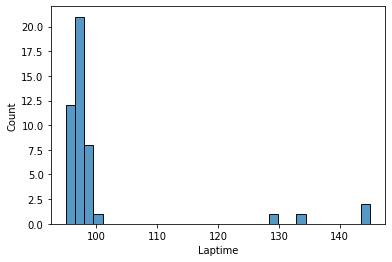

In [89]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'VER') & 
        (race_hist['Location'] == 'Sakhir') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='Laptime', ylabel='Count'>

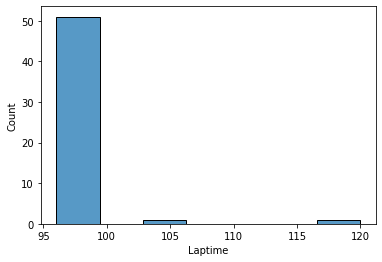

In [90]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'VER') & 
        (race_hist['Location'] == 'Sakhir') & 
        (race_hist['Year'] == 2023)]['Laptime'].astype(int))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='Laptime', ylabel='Count'>

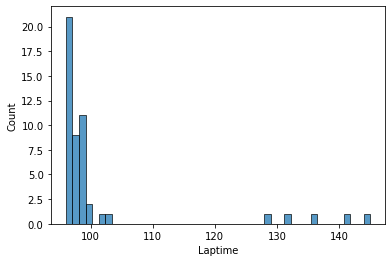

In [91]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'PER') & 
        (race_hist['Location'] == 'Sakhir') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='Laptime', ylabel='Count'>

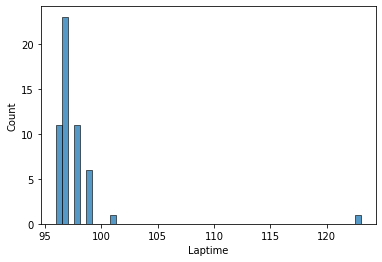

In [92]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'PER') & 
        (race_hist['Location'] == 'Sakhir') & 
        (race_hist['Year'] == 2023)]['Laptime'].astype(int))

It is visibally obvious that the dataset is highly skewed with outliers.

In [93]:
import numpy as np
import matplotlib.pyplot as plt

Potting the lap times by the lap number visually shows how the laps times are highly skewed.

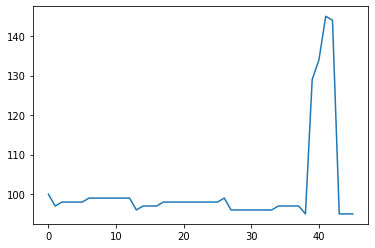

In [95]:
# Visualize how the time it took to complete a lap differs 
laptime = race_hist[(race_hist['Driver'] == 'VER') & 
        (race_hist['Location'] == 'Sakhir') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int).to_numpy()
x = np.arange(len(laptime))
plt.plot(x, list(laptime))

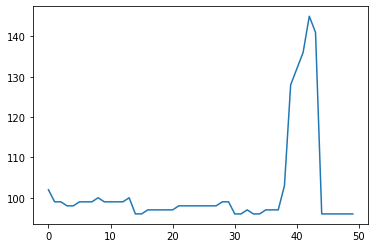

In [96]:
# Visualize how the time it took to complete a lap differs 
laptime = race_hist[(race_hist['Driver'] == 'PER') & 
        (race_hist['Location'] == 'Sakhir') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int).to_numpy()
x = np.arange(len(laptime))
plt.plot(x, list(laptime))

Since the dataset is clearly not normally distributed we will be using a Kruskal-Wallis test to see if the median values across two years in the same race between the same players are equal.

In [115]:
def kwtest(common_tracks, dnf, driver):
    tracks = list(set(common_tracks) - set(dnf))
    null_hypo = []
    alt_hypo = []
    hist = race_hist[race_hist['Driver'] == driver]
    for loc in tracks:
        dat = hist[hist['Location'] == loc]
        dat_2022 = dat[dat['Year'] == 2022]['Laptime'].astype(int)
        dat_2023 = dat[dat['Year'] == 2023]['Laptime'].astype(int)
        if stats.kruskal(dat_2022, dat_2023).pvalue < 0.05:
            alt_hypo.append((driver, loc))
        else:
            null_hypo.append((drv, loc))
    return ('alt_hypo:', alt_hypo, 'null_hypo:', null_hypo)

In [116]:
hist = race_hist[race_hist['Driver'] == 'VER']
hist[hist['Location'] == 'Yas Island']

,Driver,Year,Location,Laptime
2110,VER,2022,Yas Island,92.198
2111,VER,2022,Yas Island,90.541
2112,VER,2022,Yas Island,89.968
2113,VER,2022,Yas Island,90.368
2114,VER,2022,Yas Island,90.502
...,...,...,...,...
4487,VER,2023,Yas Island,87.513
4488,VER,2023,Yas Island,87.93
4489,VER,2023,Yas Island,87.727
4490,VER,2023,Yas Island,87.98


In [117]:
kwtest(common_tracks, dnfs, 'VER')

('alt_hypo:',
 [('VER', 'Yas Island'),
  ('VER', 'Monza'),
  ('VER', 'Miami'),
  ('VER', 'São Paulo'),
  ('VER', 'Silverstone'),
  ('VER', 'Barcelona'),
  ('VER', 'Marina Bay'),
  ('VER', 'Spa-Francorchamps'),
  ('VER', 'Baku')],
 'null_hypo:',
 [('PER', 'Jeddah'),
  ('PER', 'Austin'),
  ('PER', 'Zandvoort'),
  ('PER', 'Budapest')])

In [118]:
kwtest(common_tracks, dnfs, 'PER')

('alt_hypo:',
 [('PER', 'Yas Island'),
  ('PER', 'Monza'),
  ('PER', 'Miami'),
  ('PER', 'São Paulo'),
  ('PER', 'Barcelona'),
  ('PER', 'Marina Bay'),
  ('PER', 'Spa-Francorchamps'),
  ('PER', 'Baku')],
 'null_hypo:',
 [('PER', 'Jeddah'),
  ('PER', 'Austin'),
  ('PER', 'Silverstone'),
  ('PER', 'Zandvoort'),
  ('PER', 'Budapest')])

The results show that for the vast majority of cases the two distributions are not equal.

# Conclusion

The Kruskal Wallis test confirms that the two distributions for a driver in the same racetrack across the two years are not equal. In fact they seem to be faster on average. 

Additionally, in 2022 due to the changes in regulations the Mercedes team suffered heavily with porpoising. This lead to the team underscording compared to usual. This suggests that combining the results from 2022 and 2023 to create a large dataset would not be appropriate. 
Moreover, teams regularly repair and change vehicles between races due to DNFs or performance issues etc. Therefore fitting a model using data where a single time point is defined as a lap seems inappropriate. Instead, our model should use telemetry data to predict what would happen within a single lap. 

# Sequencing - Seasonality and Trend 

Since we are using a time series data we will see if the data shows any visible trend or seasonality that could be removed to increase the model's prediction and performance. 

In [120]:
total_tele = pd.read_csv('../../Desktop/tot_dat_bah.csv')

By plotting the telemetry data it can be shown that there exists seasonality for our data, but has no visible trend. 

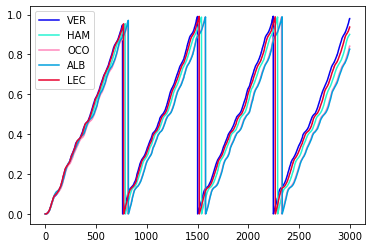

In [125]:
fig, ax = plt.subplots()
ax.plot(total_tele['VER_Distance'][0:3000], color = '#0600ef', label='VER')
ax.plot(total_tele['HAM_Distance'][0:3000], color = '#27f4d2', label='HAM')
ax.plot(total_tele['OCO_Distance'][0:3000], color = '#ff87bc', label = 'OCO' )
ax.plot(total_tele['ALB_Distance'][0:3000], color = '#00a0dd', label = 'ALB')
ax.plot(total_tele['LEC_Distance'][0:3000], color = '#e8002d', label = 'LEC')
ax.legend()

plt.show()

This seasonality occurs because the drivers are going around tracks. However, as shown in the plot below as the drivers are going at different paces this seasonlity becomes irregular and unique for each driver. 

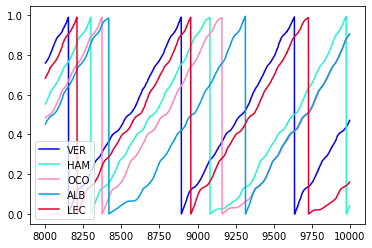

In [127]:
fig, ax = plt.subplots()
ax.plot(total_tele['VER_Distance'][8000:10000], color = '#0600ef', label='VER')
ax.plot(total_tele['HAM_Distance'][8000:10000], color = '#27f4d2', label='HAM')
ax.plot(total_tele['OCO_Distance'][8000:10000], color = '#ff87bc', label = 'OCO' )
ax.plot(total_tele['ALB_Distance'][8000:10000], color = '#00a0dd', label = 'ALB')
ax.plot(total_tele['LEC_Distance'][8000:10000], color = '#e8002d', label = 'LEC')
ax.legend()

plt.show()

Thus we will fit our data without removing trend or seasonality, as removing seasonality from one driver means we have to remove it for all other drivers with the same cyclicality.